###  一、SIFT特征提取
使用尺度不变特征变换（SIFT）算法从每张图像中提取关键点和描述符。SIFT能够提取出图像中的关键特征，并且对旋转、尺度缩放、亮度变化等具有良好的不变性。
对于每张图像，将提取出的SIFT特征存储为向量形式，这将构成图像的特征表示。

#### 1.1 Image_SIFT类提取sift特征

In [1]:
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import cv2
class Image_SIFT:
    """
    输入一张图片，提取SIFT特征
    """
    def __init__(self,
                 image,
                 label: Optional[int] = None):
        """初始化

        Args:
            image (_type_): 图片
            label (Optional[int], optional): 标签. Defaults to None.
        """
        if image.shape[2] == 3:
            # 转换为灰度
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.image = image  # 这个应该得是灰度图
        self.label = label
        self.keypoints = None
        self.descriptors = None
        self.image_path = None
        
    def sift_transform(self):
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(self.image, None)
        self.keypoints = keypoints
        self.descriptors = descriptors
        return keypoints, descriptors
    
    def sift_normalize(self):
        normalized_descriptors = []
        for descriptor in self.descriptors:
            norm = np.linalg.norm(descriptor)
            if norm > 0:
                normalized_descriptor = descriptor / norm
            else:
                normalized_descriptor = descriptor
            normalized_descriptors.append(normalized_descriptor)
        self.descriptors = normalized_descriptors
        return normalized_descriptors
    
    def show_sift_keypoints(self):
        """可视化sift特征点
        """
        sift_image = cv2.drawKeypoints(self.image, self.keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # 使用matplotlib显示图像
        plt.imshow(cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB))
        plt.title('SIFT Keypoints')
        plt.show()

(200, 267, 3)
第一个关键点的坐标： 5.407073974609375 120.53779602050781
第一个关键点的描述符： [0.01171011 0.06050223 0.03513033 0.00195168 0.00390337 0.00585505
 0.         0.         0.00390337 0.01561348 0.06830897 0.0390337
 0.00195168 0.00195168 0.02732359 0.01171011 0.         0.
 0.01756516 0.02927527 0.00390337 0.00390337 0.04684044 0.00585505
 0.         0.         0.         0.         0.         0.
 0.         0.         0.04098538 0.01756516 0.02732359 0.00585505
 0.0390337  0.13661794 0.01171011 0.03317864 0.22639544 0.01756516
 0.01561348 0.00585505 0.00195168 0.01951685 0.24786398 0.28689766
 0.01756516 0.         0.         0.00390337 0.00195168 0.11319772
 0.28689766 0.08197077 0.         0.         0.         0.
 0.         0.00390337 0.00390337 0.         0.05464717 0.00195168
 0.         0.         0.01366179 0.28689766 0.08782582 0.02146853
 0.28689766 0.07611571 0.         0.         0.         0.07221234
 0.06635728 0.15027973 0.1932168  0.01561348 0.         0.
 0.00390337 0.2185887

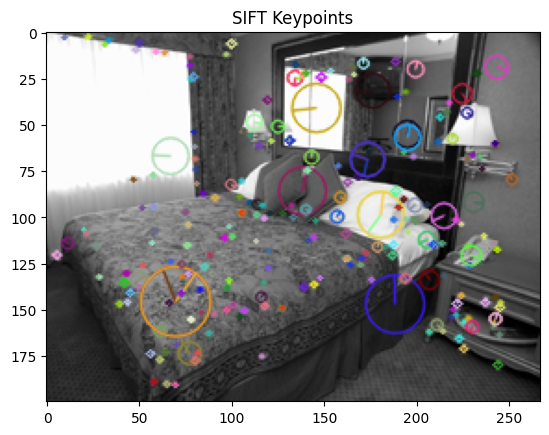

In [2]:
image = cv2.imread('./15-Scene/00/1.jpg')
print(image.shape)
image_sift = Image_SIFT(image,label=00)
keypoints, descriptors = image_sift.sift_transform()
normalized_descriptors = image_sift.sift_normalize()
x, y = keypoints[0].pt
print("第一个关键点的坐标：", x, y)
print("第一个关键点的描述符：", image_sift.descriptors[0])
image_sift.show_sift_keypoints()

#### 1.2 训练集和测试集的数据加载

In [3]:
# 训练集和测试集的生成
import os
from typing import Optional
import pickle

def load_image_get_set(image_path: Optional[str] = None,
                       descriptors_save_path: Optional[str] ='./data/descriptors.dat'):
    """加载图片，遍历文件夹，对前150张图片提取sift特征，然后加入到list,之后对这2250*feature特征聚类，得到聚类中心，之后对每张图片提取sift特征，然后用这个图片的sift特征与聚类中心进行比较，得到这个图片的特征向量，之后用这个特征向量进行训练

    Args:
        image_path (Optional[str], optional): 文件夹目录. Defaults to None.
    """
    # 列出子目录，也就是每个种类的目录
    class_dirs = os.listdir(image_path)
    print(class_dirs)
    lable = 0
    
    train_data = []
    test_data = []
    # 所有的128维向量
    descriptors_list = None
    for class_dir in class_dirs:
        image_class_dir = os.path.join(image_path, class_dir)  # 每一个文件夹的路径
        image_files = os.listdir(image_class_dir)  # 每一个文件夹下的图片
        
        print(f'处理{class_dir}')
        # 对于前150张图片
        for i in range(150):
            image_file_path = os.path.join(image_class_dir, image_files[i])
            image = cv2.imread(image_file_path)
            # 提取sift特征
            image_sift = Image_SIFT(image,label=lable)
            image_sift.sift_transform()
            normalized_descriptors = image_sift.sift_normalize()
            image_sift.image_path = image_file_path
            train_data.append(image_sift)  # 放到训练集上
            # 向量拼接
            normalized_descriptors = np.array(normalized_descriptors)
            descriptors_list = np.vstack((descriptors_list,normalized_descriptors)) if descriptors_list is not None else normalized_descriptors
            
            # 加一个看图片形状的判定
            if class_dir=='01' and image_sift.image.shape[0] ==200:
                print(image_file_path)
                print(image_sift.image.shape)  
        
        for i in range(150, len(image_files)):
            image_file_path = os.path.join(image_class_dir, image_files[i])
            image = cv2.imread(image_file_path)
            # 提取sift特征
            image_sift = Image_SIFT(image,label=lable)
            image_sift.sift_transform()
            normalized_descriptors = image_sift.sift_normalize()
            test_data.append(image_sift)
        lable += 1
    print(descriptors_list.shape)
    with open(descriptors_save_path, 'wb') as f:
        pickle.dump(descriptors_list, f)
    return train_data, test_data
train_dataset, test_dataset=load_image_get_set('./15-Scene')

    

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']
处理00
处理01
处理02
处理03
处理04
处理05
处理06
处理07
处理08
处理09
处理10
处理11
处理12
处理13
处理14
(1133764, 128)


In [4]:
def save_dataset(save_folder, train_dataset, test_dataset):
    """保存数据集
    """
    print('开始保存数据集')
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    with open(os.path.join(save_folder, 'train_dataset.dat'), 'wb') as f:
        pickle.dump(train_dataset, f)
    with open(os.path.join(save_folder, 'test_dataset.dat'), 'wb') as f:
        pickle.dump(test_dataset, f)
def load_dataset(save_path):
    """加载数据集
    """
    print('开始加载数据集')
    with open(save_path, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

### 二、BogOFVisualWords
由于SIFT特征维度较高，直接使用可能会导致计算复杂度过高，因此可以使用K-means算法对特征进行聚类降维。
通过K-means算法，可以将SIFT描述符划分为K个聚类中心，每个中心代表一个视觉词汇。这样，每张图像的特征就可以用这些视觉词汇的分布来表示，即词袋表示。

In [6]:
from sklearn.cluster import MiniBatchKMeans
import math
class BagOFVisualWords:
    """处理SIFT向量，KMeans聚类，生成聚类中心，然后使用SPM算法，进行词袋投票，生成图片的描述向量，
    """
    def __init__(self,
                 descriptors_list_path: Optional[str] = './data/descriptors.dat'):
        """初始化变量的参数

        Args:
            descriptors_list_path (Optional[str], optional): _description_. Defaults to './data/descriptors.dat'.
        """
        self.descriptors_list_path = descriptors_list_path
        self.k = None
        self.descriptors_list = None
        self.center = None
        
        
    def kmeans_get_center(self,
                          descriptors_list: Optional[np.ndarray] = None,
                          k: Optional[int] =  200,
                          random_state: Optional[int] = 42,
                          center_save_path: Optional[str] = './data/center.dat'):
        """kmeans聚类，得到中心

        Args:
            descriptors_list (Optional[np.ndarray], optional): 之前提取的所有训练集的descriptors向量. Defaults to None.
            k (Optional[int], optional): 聚类中心数量. Defaults to 200.
            random_state (Optional[int], optional): 随机数种子. Defaults to 42.
            center_save_path (Optional[str], optional): 保存路径. Defaults to './data/center.dat'.

        Raises:
            ValueError: _description_

        Returns:
            _type_: _description_
        """
        if not os.path.exists(self.descriptors_list_path) and descriptors_list is None:
            raise ValueError('请先提取sift特征')
        if descriptors_list is None:
            with open(self.descriptors_list_path, 'rb') as f:
                self.descriptors_list = pickle.load(f)
        self.k = k
        
        # kmeans聚类
        np.random.shuffle(self.descriptors_list)
        kmeans_ans = MiniBatchKMeans(n_clusters=self.k, random_state=random_state).fit(self.descriptors_list)
        self.center = kmeans_ans.cluster_centers_
        with open(center_save_path, 'wb') as f:
            pickle.dump(self.center, f)
        return self.center
    
    def load_kmeans_center(self,
                           center_path: Optional[str] = './data/center.dat'):
        """加载kmeans聚类中心

        Args:
            center_path (Optional[str], optional): _description_. Defaults to './data/center.dat'.

        Returns:
            _type_: 中心
        """
        with open(center_path, 'rb') as f:
            self.center = pickle.load(f)
        return self.center
    
    def spm_vote_get_vector(self,
                            image,
                            level: Optional[int] = 2,
                            point_descriptors: Optional[np.ndarray] = None,
                            point_keypoints: Optional[np.ndarray] = None,
                            image_path: Optional[str] = None
                            ):
        """
        根据SPM算法，生成不同尺度下对我们视觉中心的投票向量，以此来代表图片
        """
        if self.center is None:
            raise ValueError("未初始化K均值中心。请先调用'kmeans_get_center'或'load_kmeans_center'方法。")
        num_of_vector = len(point_descriptors)  # 一个图片的特征点数量
        feature_vector2 = np.zeros((2**(level+2),self.k))  # 从小向大投票,
        image_y, image_x = image.shape
        step_x = math.ceil(image_x / (level**2))
        step_y = math.ceil(image_y / (level**2))
        
        # 开始对于每个向量投票
        for i in range(num_of_vector):
            x, y = point_keypoints[i].pt
            # 
            index_1 = math.floor(x / step_x) * (level**2) + math.floor(y / step_y)  # 第几个图片区域
            
            index_2 = np.argmin(np.linalg.norm(self.center - point_descriptors[i], axis=1))
            # if(index_1>=15):
            #     print(i)
            #     index_1 = 15
            #     print(image)
            #     print('x:',x,'y:',y,'step_x:',step_x,'step_y:',step_y,'level:',level,'image_x:',image_x,'image_y:',image_y)
            feature_vector2[index_1][index_2] += 1

        # 填充上一层
        feature_vector1 = np.zeros((2**level,self.k))
        for i in range(level**2):
            for j in range(level**2):
                feature_vector1[i] += feature_vector2[i*(level**2)+j]
        
        # 再填充一层
        feature_vector0 = np.zeros((1,self.k))
        for i in range(4):
            feature_vector0 += feature_vector1[i]
        
        # 对每个特征向量进行归一化
        normalized_feature_vector0 = feature_vector0 / np.linalg.norm(feature_vector0)
        normalized_feature_vector1 = feature_vector1 / np.linalg.norm(feature_vector1)
        normalized_feature_vector2 = feature_vector2 / np.linalg.norm(feature_vector2)

        # 展平归一化后的特征向量
        flatten_normalized_feature_vector0 = normalized_feature_vector0.flatten()
        flatten_normalized_feature_vector1 = normalized_feature_vector1.flatten()
        flatten_normalized_feature_vector2 = normalized_feature_vector2.flatten()

        # 将展平后的特征向量进行拼接
        feature_vector = np.hstack((flatten_normalized_feature_vector0, flatten_normalized_feature_vector1, flatten_normalized_feature_vector2))
        
        return feature_vector
    
    def process_dataset(self, data):
        """批量处理数据，构建训练数据集

        Args:
            data (_type_): _description_
        """
        print('开始处理数据集')
        dataset = []
        labels = []
        for item in data:
            # train_vector ->[1,2100]
            train_vector = self.spm_vote_get_vector(level=2,
                                                    image = item.image,
                                                    point_descriptors=item.descriptors,
                                                    point_keypoints=item.keypoints,
                                                    image_path=item.image_path)
        
            dataset.append(train_vector)
            labels.append(item.label)
        # 转换为np
        dataset = np.array(dataset)
        labels = np.array(labels)
        print('向量构建完毕')
        return dataset, labels
        
bow = BagOFVisualWords()


In [7]:
center = bow.kmeans_get_center()
train_vector, train_labels = bow.process_dataset(train_dataset)


e:\SoftWare\Program\Anaconda\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


开始处理数据集
向量构建完毕


In [8]:
test_vector, test_labels = bow.process_dataset(test_dataset)

开始处理数据集
向量构建完毕


### 三、SVM_model
使用训练好的SVM模型对测试集中的图像进行分类预测。
评估模型的性能，常用的评估指标包括准确率、召回率、F1分数等。可以通过混淆矩阵来直观地查看模型在各个类别上的表现。

In [9]:
from sklearn import svm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
class SVM_model:
    def __init__(self):

        self.model = None
        
    def train(self, 
            data: Optional[np.ndarray]=None, 
            labels: Optional[np.ndarray]=None,
            C_range: Optional[tuple] = (1, 50, 2)):
        
        print('开始训练模型')
        data = np.array(data)
        labels = np.array(labels)
        
        # 定义C值的范围
        C_values = np.arange(C_range[0], C_range[1]+1, C_range[2])
        
        # 创建GridSearchCV对象
        param_grid = {'C': C_values}
        grid_search = GridSearchCV(estimator=svm.SVC(kernel='rbf', decision_function_shape='ovo'), 
                                   param_grid=param_grid, cv=5, n_jobs=-1)
        
        # 执行网格搜索
        grid_search.fit(data, labels)
        
        # 获取最佳模型
        best_model = grid_search.best_estimator_
        self.model = best_model
        
        print("最佳C值:", best_model.C)
        
        # 可视化网格搜索结果
        scores = grid_search.cv_results_['mean_test_score']
        plt.figure(figsize=(10, 6))
        plt.plot(C_values, scores, marker='o')
        plt.title('Grid Search Results')
        plt.xlabel('C Value')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
        
    def train_test(self, 
              data: Optional[np.ndarray]=None, 
              labels: Optional[np.ndarray]=None,
              C: Optional[int] = 20,):
        print('开始训练模型')
        data = np.array(data)
        labels = np.array(labels)
        rbf_class = svm.SVC(kernel='rbf', C=20, decision_function_shape='ovo')
        rbf_class.fit(data, labels)
        self.model = rbf_class
        return rbf_class
    
    def save_model(self,
                   model_path: Optional[str] = './data/model.dat'):
        with open(model_path, 'wb') as f:
            pickle.dump(self.model, f)
            print('模型保存成功')
            
    def load_model(self,
                   model_path: Optional[str] = './data/model.dat'):
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
            print('模型加载成功')
            
    def predict(self, data):
        if self.model is None:
            raise ValueError('请先加载模型')
        data = np.array(data)
        return self.model.predict(data)
        
    
    def evaluate(self, prediction, labels):
        # Confusion Matrix
        cm = confusion_matrix(labels, prediction)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()
        
    
        
        # Classification Report
        report = classification_report(labels, prediction)
        print("Classification Report:\n", report)

        acc = np.mean(prediction == labels)
        return acc
    

开始训练模型
最佳C值: 3


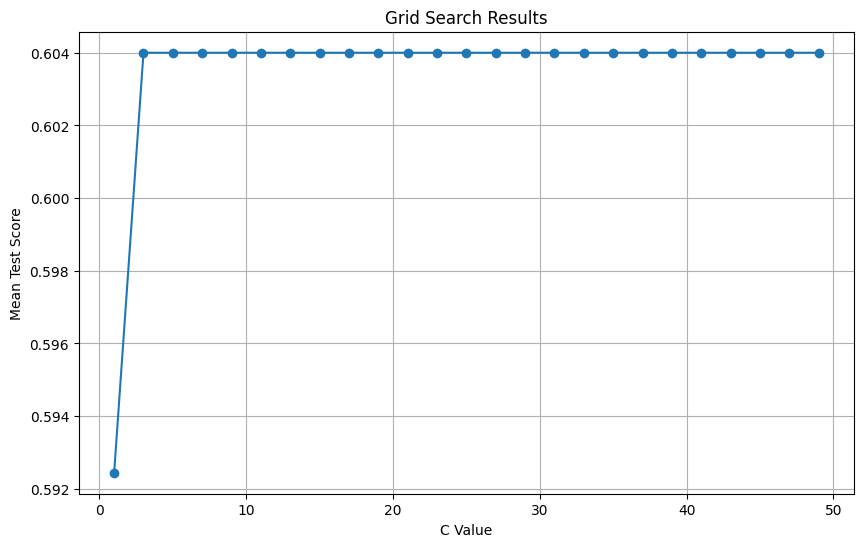

In [10]:
svm_model = SVM_model()
rbf_class = svm_model.train(train_vector, train_labels)
predict_labls = svm_model.predict(test_vector)


In [11]:
svm_model.save_model()

模型保存成功


In [12]:
svm_model = SVM_model()
svm_model.load_model()

模型加载成功


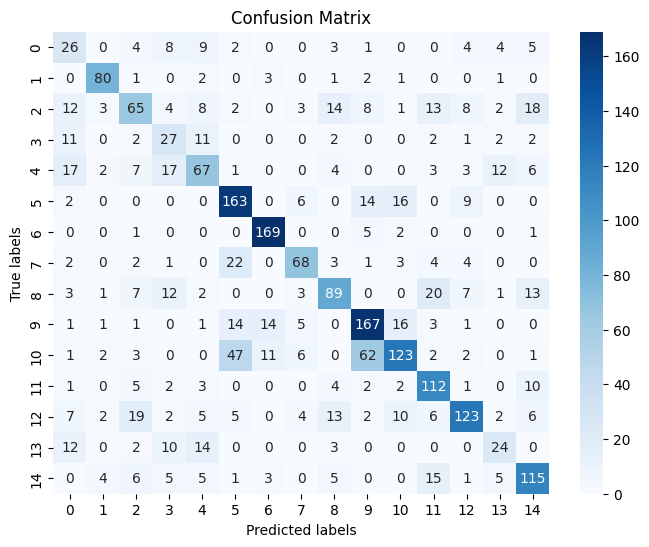

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.39      0.32        66
           1       0.84      0.88      0.86        91
           2       0.52      0.40      0.45       161
           3       0.31      0.45      0.36        60
           4       0.53      0.48      0.50       139
           5       0.63      0.78      0.70       210
           6       0.84      0.95      0.89       178
           7       0.72      0.62      0.66       110
           8       0.63      0.56      0.60       158
           9       0.63      0.75      0.68       224
          10       0.71      0.47      0.57       260
          11       0.62      0.79      0.70       142
          12       0.75      0.60      0.66       206
          13       0.45      0.37      0.41        65
          14       0.65      0.70      0.67       165

    accuracy                           0.63      2235
   macro avg       0.61      0.61      0.60      2235
we

In [13]:
ans = svm_model.evaluate(predict_labls, test_labels)
print(ans)

### 一些超参数
k=100,0.5843400447427293
k=64,0.5825503355704698

k=200,0.6098434004474272 c=10,0.611185682326622
C=15 0.6125279642058166
c=20 0.6138702460850112
c=30 .611185682326622
c=50 0.6120805369127517